# ARTEFACT case - processo seletivo: 3A & 3B

In this exercise, they ask us to check whether the *salaries* of the employees in a supermarket company are **significantly** different according to their *location*. For that purpose, I am going to set a priori a significance level of 5%.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

First of all, I am going to load the data from the .xlsx file provided, and to check that all the entries are free of null values.

In [3]:
data = pd.read_excel('database.xlsx','Sheet3')
data.shape

(80, 7)

In [4]:
data.head()

,ID,EDUCAÇÃO,CARGO,LOCAL,IDADE,TEMPOCASA,SALARIO_MENSAL
0,1.0,SECUNDÁRIO,GERENTE,INTERIOR,30.0,1.0,4279.5
1,2.0,SUPERIOR,AUXILIAR,INTERIOR,32.0,4.0,4575.4
2,3.0,SECUNDÁRIO,AUXILIAR,CAPITAL,33.0,2.0,4735.6
3,4.0,SUPERIOR,GERENTE,INTERIOR,34.0,3.0,4863.1
4,5.0,SECUNDÁRIO,GERENTE,INTERIOR,36.0,1.0,5355.8


In [5]:
data.tail()

,ID,EDUCAÇÃO,CARGO,LOCAL,IDADE,TEMPOCASA,SALARIO_MENSAL
75,78.0,SUPERIOR,GERENTE,CAPITAL,65.0,25.0,7257.0
76,79.0,SUPERIOR,AUXILIAR,INTERIOR,67.0,15.0,6235.1
77,80.0,SUPERIOR,DIRETOR,CAPITAL,69.0,21.0,7257.0
78,81.0,SUPERIOR,DIRETOR,CAPITAL,70.0,22.0,7481.2
79,82.0,SUPERIOR,AUXILIAR,CAPITAL,72.0,22.0,6415.8


In [6]:
data.isnull().sum() # There are not NULL values

ID                0
EDUCAÇÃO          0
CARGO             0
LOCAL             0
IDADE             0
TEMPOCASA         0
SALARIO_MENSAL    0
dtype: int64

First thing I notice from the size of the dataframe is that there are some missing IDs on the first column. It is more a curiosity than a real problem. Could be that those employees are not staff of the company anymore.

In [7]:
missing_IDs = [id for id in range(1,82) if id not in data['ID'].values]
missing_IDs

[17, 66]

The important columns for the exercise are `data['LOCAL']` and `data['SALARIO_MENSAL']`. The rest is just additional information. Let us extract then the salary information from the dataset and split it in separate variables corresponding to the possible locations of the employee.

In [8]:
data = data[['LOCAL', 'SALARIO_MENSAL']]
data['LOCAL'].unique().tolist()

['INTERIOR', 'CAPITAL']

In [9]:
sal_int = data.query('LOCAL == "INTERIOR"').SALARIO_MENSAL
sal_cap = data.query('LOCAL == "CAPITAL"').SALARIO_MENSAL

We can take a look at some of the statistics and plot histograms to get an idea about how the values are distributed on both groups.

In [10]:
resume = pd.DataFrame({'Interior_Salary': sal_int.describe(), 'Capital_Salary': sal_cap.describe()})
resume

,Interior_Salary,Capital_Salary
count,35.000000,45.000000
mean,5368.868571,6095.542222
std,718.191711,1300.428122
min,4186.600000,4434.600000
25%,4878.700000,5131.200000
50%,5254.400000,6051.300000
75%,5917.700000,6583.900000
max,6796.900000,12465.800000


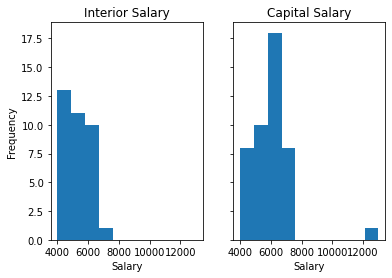

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True)

ax1.set_title('Interior Salary')
ax1.set_xlabel('Salary')
ax1.set_ylabel('Frequency')
ax1.hist(sal_int, range=(4000, 13000))

ax2.set_title('Capital Salary')
ax2.set_xlabel('Salary')
ax2.hist(sal_cap, range=(4000, 13000))

plt.show()

Clearly the difference between the mean values `5368.9 <-> 6095.5` is not negligible. It might be possible that the outlier around `12000` is causing the discrepancy. We will check that later as well.

However, in order to check this discrepancy rigorously, we should also take into account the variances and work around a contrast hypothesis.

# Student's t-test: Welch's t-test

Initially I am going to consider a Null-Hypothesis in which the salaries of the employees in both locations are similar, i.e.

In [12]:
display(Math(r'\text{Null-hypothesis:}\quad H_0\equiv \bar X_\text{salary}^\text{INTERIOR}\sim\bar X_\text{salary}^\text{CAPITAL}'))

<IPython.core.display.Math object>

These are my samples...

In [13]:
resume.loc[['mean', 'std'],:]

,Interior_Salary,Capital_Salary
mean,5368.868571,6095.542222
std,718.191711,1300.428122


... in which we observe two different mean values and also two *different variances*.

To check my Null-Hypothesis $H_0$, I am going to perform a **Student's t-test** (**Welch's t-test**) and compare the resulting t-statistic `t` with the corresponding critial value `z_alpha` for a significance of 5%.

In [14]:
# Manually

def t_test(sample1, sample2):
    se1 = sample1.std()/np.sqrt(len(sample1))
    se2 = sample2.std()/np.sqrt(len(sample2))
    sed = np.sqrt(se1**2 + se2**2)
    return (sample1.mean()-sample2.mean())/sed

print('t = {}'.format(t_test(sal_int, sal_cap)))

t = -3.1769929863941986


In [15]:
# Using SciPy (for completeness)

from scipy.stats import ttest_ind

t, p = ttest_ind(sal_int, sal_cap, equal_var=False)
print('t = {} , pvalue = {}'.format(t, p))

t = -3.176992986394198 , pvalue = 0.002202071572835849


The critical value `z_alpha` for a significance level of 5% can be obtained by solving the equation presented on the .pdf file for `nu = len(data)-2 = 78` degrees of freedom, but since there already exist tables for those kind of integrals, we can just consult it on the internet. For a 2-tail contrast hypothesis, significance of 5% corresponds to `z_alpha = 1.99`.

Therefore...

In [16]:
display(Math(r'|t| = 3.177 > z_\alpha = 1.990 \quad\Rightarrow\quad \text{Reject Null-Hypothesis}\quad\Rightarrow\quad\text{Employees from different locations DO have different salaries}'))

<IPython.core.display.Math object>

### Conclusion: *The supermarket company **is not** following the new policy.*

# Student's t-test: Welch's t-test without the outlier

We can repeat the whole process discarding the outlier around 12000 R$ for the employee at the capital.

In [17]:
sal_int = data.query('LOCAL == "INTERIOR"').SALARIO_MENSAL
sal_cap = data.query('LOCAL == "CAPITAL" & SALARIO_MENSAL < 10000').SALARIO_MENSAL
resume = pd.DataFrame({'Interior_Salary': sal_int.describe(), 'Capital_Salary': sal_cap.describe()})
print(resume)

       Interior_Salary  Capital_Salary
count        35.000000       44.000000
mean       5368.868571     5950.763636
std         718.191711      874.795978
min        4186.600000     4434.600000
25%        4878.700000     5131.150000
50%        5254.400000     5978.250000
75%        5917.700000     6583.900000
max        6796.900000     7481.200000


In [18]:
t_without_outlier, pvalue = ttest_ind(sal_int, sal_cap, equal_var=False)
print("t' = {}".format(t_without_outlier))

t' = -3.246326225631877


Therefore...

In [19]:
display(Math(r"|t'| = 3.246 > z_\alpha = 1.990 \quad\Rightarrow\quad \text{Reject Null-Hypothesis}\quad\Rightarrow\quad\text{Employees from different locations STILL have different salaries}"))

<IPython.core.display.Math object>

### Conclusion: *The supermarket company **is still not** following the new policy even without the outlier.*